<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [150]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline
import warnings
warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [151]:
import urllib.request
path = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv'
filename = 'loan_train.csv'
urllib.request.urlretrieve(path, filename)


('loan_train.csv', <http.client.HTTPMessage at 0x1ef53a05ba0>)

### Load Data From CSV File


In [152]:
df = pd.read_csv(filename, index_col=False)
df.drop(columns=['Unnamed: 0','Unnamed: 0.1'], inplace=True)
df.head()


,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [153]:
df.shape

(346, 8)

### Convert to date time object


In [154]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [155]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


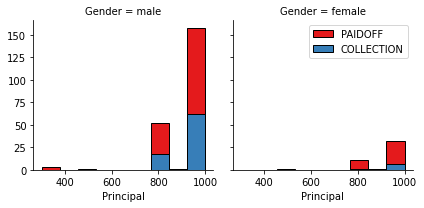

In [156]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

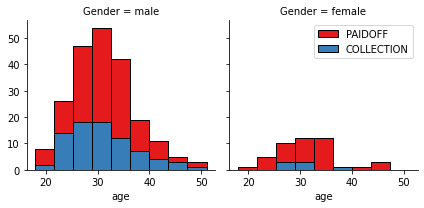

In [157]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


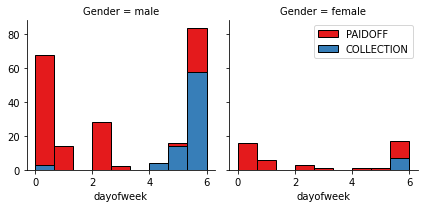

In [158]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [159]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [160]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [161]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [162]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [163]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical variables to binary variables and append them to the feature Data Frame


In [164]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [165]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [166]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [167]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.52,  0.92,  2.33, -0.42, -1.21, -0.38,  1.14, -0.87],
       [ 0.52,  0.92,  0.34,  2.38, -1.21,  2.62, -0.88, -0.87],
       [ 0.52, -0.96, -0.65, -0.42, -1.21, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.49,  2.38,  0.83, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.32, -0.42,  0.83, -0.38, -0.88,  1.15]])

## Separate Train and Test set

In [168]:
import urllib.request
path = 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv'
filename = 'loan_test.csv'
urllib.request.urlretrieve(path, filename)

test_df = pd.read_csv('loan_test.csv')
test_df.drop(columns=["Unnamed: 0","Unnamed: 0.1"], inplace=True)
test_df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [169]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [170]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import jaccard_score


# Building model:
Ks = 7
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.66, 0.59, 0.74, 0.7 , 0.74, 0.71])

## Plot the model accuracy for a different number of neighboors (k)

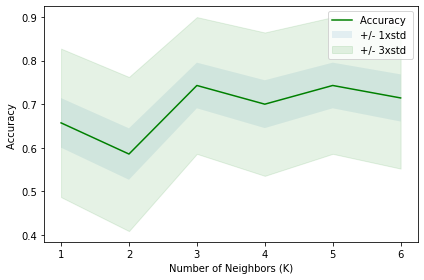

In [171]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [172]:
# Building model with best k:
Ks = 7
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = Ks).fit(X_train,y_train)
yhat=neigh.predict(X_test)
mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)


std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.79])

In [173]:
print( "The best accuracy was with",knn_acc , "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.79 with k= 6


In [174]:
KNN_acc = metrics.accuracy_score(y_test, yhat)
KNN_F1 = f1_score(y_test, yhat, average='weighted')
KNN_jaccard=jaccard_score(y_test, yhat, pos_label='PAIDOFF')

print(f"KNN's Accuracy with k = {Ks}: {KNN_acc:.2}")
print(f"KNN's F-Score with k = {Ks}: {KNN_F1:.2}")
print(f"KNN's Jaccard with k = {Ks}: {KNN_jaccard:.2}")

KNN's Accuracy with k = 7: 0.79
KNN's F-Score with k = 7: 0.79
KNN's Jaccard with k = 7: 0.76


# Decision Tree


In [175]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
from sklearn.metrics import f1_score


for n in range(1,10):
    # Building the model
    loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    loanTree.fit(X_train, y_train)

    # make predictions
    preds = loanTree.predict(X_test)
    
    tree_F1 = f1_score(y_test, preds, average='weighted') 

    # evaluate the model
    print(f"DecisionTrees's Accuracy with max_depth = {n}: {metrics.accuracy_score(y_test, preds):.2} //// F1-Score: {tree_F1}")


DecisionTrees's Accuracy with max_depth = 1: 0.79 //// F1-Score: 0.6914285714285714
DecisionTrees's Accuracy with max_depth = 2: 0.79 //// F1-Score: 0.6914285714285714
DecisionTrees's Accuracy with max_depth = 3: 0.61 //// F1-Score: 0.6445993031358885
DecisionTrees's Accuracy with max_depth = 4: 0.61 //// F1-Score: 0.6445993031358885
DecisionTrees's Accuracy with max_depth = 5: 0.64 //// F1-Score: 0.6741854636591479
DecisionTrees's Accuracy with max_depth = 6: 0.77 //// F1-Score: 0.7064793130366899
DecisionTrees's Accuracy with max_depth = 7: 0.76 //// F1-Score: 0.6978810663021189
DecisionTrees's Accuracy with max_depth = 8: 0.76 //// F1-Score: 0.6978810663021189
DecisionTrees's Accuracy with max_depth = 9: 0.66 //// F1-Score: 0.6758241758241758


In [176]:
# # Building the model
max_depth = 2
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = max_depth)
loanTree.fit(X_train, y_train)

# make predictions
preds = loanTree.predict(X_test)

# evaluate the model
tree_acc = metrics.accuracy_score(y_test, preds)
tree_F1 = f1_score(y_test, preds, average='weighted')
tree_jaccard=jaccard_score(y_test, preds, pos_label='PAIDOFF')


print(f"DecisionTrees's Accuracy with max_depth = {max_depth}: {tree_acc:.2}")
print(f"DecisionTrees's F-Score with max_depth = {max_depth}: {tree_F1:.2}")
print(f"DecisionTrees's Jaccard with max_depth = {max_depth}: {tree_jaccard:.2}")

DecisionTrees's Accuracy with max_depth = 2: 0.79
DecisionTrees's F-Score with max_depth = 2: 0.69
DecisionTrees's Jaccard with max_depth = 2: 0.79


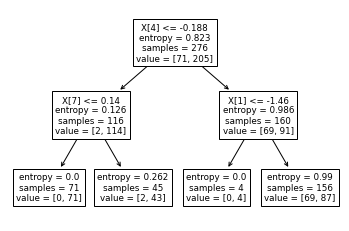

In [177]:
tree.plot_tree(loanTree)
plt.show()

# Support Vector Machine


In [178]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [179]:
from sklearn import svm

# build the model:
clf_SVM = svm.SVC(kernel='rbf')

# Train
clf_SVM.fit(X_train, y_train)

# Predict
yhat = clf_SVM.predict(X_test)

#Evaluate the Model:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
    
print (classification_report(y_test, yhat))



              precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

    accuracy                           0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70



Confusion matrix, without normalization
[[ 4 11]
 [ 7 48]]


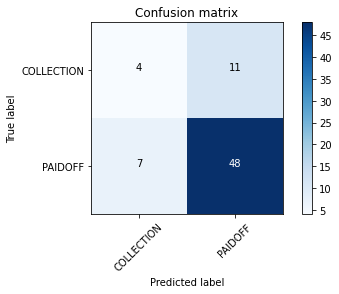

In [180]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'],normalize= False,  title='Confusion matrix')

In [181]:
# evaluate the model
SVM_acc = metrics.accuracy_score(y_test, yhat)
SVM_F1 = f1_score(y_test, yhat, average='weighted')
SVM_jaccard=jaccard_score(y_test, yhat, pos_label='PAIDOFF')


print(f"SVM's Accuracy = {SVM_acc:.2}")
print(f"DecisionTrees's F1-Score = {SVM_F1:.2}")
print(f"DecisionTrees's Jaccard = {SVM_jaccard:.2}")

SVM's Accuracy = 0.74
DecisionTrees's F1-Score = 0.73
DecisionTrees's Jaccard = 0.73


# Logistic Regression


In [182]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss


solver_list = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
for s in solver_list:
    LR = LogisticRegression(C=0.01, solver=s).fit(X_train,y_train)

    yhat = LR.predict(X_test)
    yhat_prob = LR.predict_proba(X_test)

    xx=log_loss(y_test, yhat_prob)
    
    print(f"Classification Report with solver {s}:")
    print(classification_report(y_test, yhat))
    print("*"*55)
    print(f"logLoss with solver {s}: {xx}")
    print("/"*55)



Classification Report with solver newton-cg:
              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        15
     PAIDOFF       0.79      1.00      0.88        55

    accuracy                           0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70

*******************************************************
logLoss with solver newton-cg: 0.492017801467927
///////////////////////////////////////////////////////
Classification Report with solver lbfgs:
              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        15
     PAIDOFF       0.79      1.00      0.88        55

    accuracy                           0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70

*******************************************************
logLoss with solver lbfgs: 0.49201798479374

C:\Users\Maxter\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Maxter\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Maxter\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [195]:
# Model with the best `solver` parameter = newton-cg

LR = LogisticRegression(C=0.01, solver='newton-cg').fit(X_train,y_train)
yhat = LR.predict(X_test)
yhat_prob = LR.predict_proba(X_test)

print (classification_report(y_test, yhat, zero_division='warn'))



              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        15
     PAIDOFF       0.79      1.00      0.88        55

    accuracy                           0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70



C:\Users\Maxter\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Maxter\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Maxter\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Confusion matrix, without normalization
[[ 0 15]
 [ 0 55]]


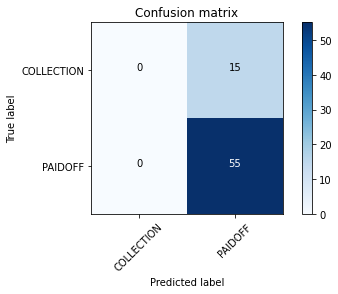

In [184]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'],normalize= False,  title='Confusion matrix')

In [185]:
LR_accuracy = metrics.accuracy_score(y_test, yhat)

LR_log_loss = log_loss(y_test, yhat_prob)

LR_jaccard=round(jaccard_score(y_test, yhat, pos_label='PAIDOFF'),2)

LR_F1score = f1_score(y_test, yhat, average='weighted')

print(f"Accuracy: {LR_accuracy:.2}")
print(f"F1-score: {LR_F1score:.2}")
print(f"Jaccard: {LR_jaccard:.2}")
print(f"Logloss: {LR_log_loss:.2}")



Accuracy: 0.79
F1-score: 0.69
Jaccard: 0.79
Logloss: 0.49


# Model Evaluation


In [186]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


In [187]:
models_metrics = pd.DataFrame(columns=['Model','F1-score','Jaccard','LogLoss'])
models_metrics.loc[0] = ['KNN',KNN_F1, KNN_jaccard, np.nan ]
models_metrics.loc[1] = ['Tree Classifier',tree_F1, tree_jaccard, np.nan ]
models_metrics.loc[2] = ['SVM',SVM_f1, SVM_jaccard, np.nan ]
models_metrics.loc[3] = ['Logistic Regression',LR_F1score, LR_jaccard, LR_log_loss ]


models_metrics

,Model,F1-score,Jaccard,LogLoss
0,KNN,0.788188,0.758065,NaN
1,Tree Classifier,0.691429,0.785714,NaN
2,SVM,0.727588,0.727273,NaN
3,Logistic Regression,0.691429,0.790000,0.492018


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
